<a href="https://colab.research.google.com/github/julienierwinski/Data-Mining-Stock-Market/blob/main/StockAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Get the Polygon API key for access to data.
from google.colab import userdata
API_KEY = userdata.get('POLYGON')

In [2]:
pip install -U polygon-api-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00


In [3]:
from polygon import RESTClient
from polygon.rest import models


client = RESTClient(API_KEY) # api_key is used


✅ Data pulled: Ticker
META    25
MSFT    25
NVDA    25
dtype: int64
✅ Features added: ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Return', 'MA5', 'MA10', 'Volatility', 'Future_Return', 'Target']
✅ Model trained. Accuracy: 0.556
✅ Simulation complete.
Final portfolio value: 99974.69


/tmp/ipython-input-434012029.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("Ticker", group_keys=False).apply(add_features)


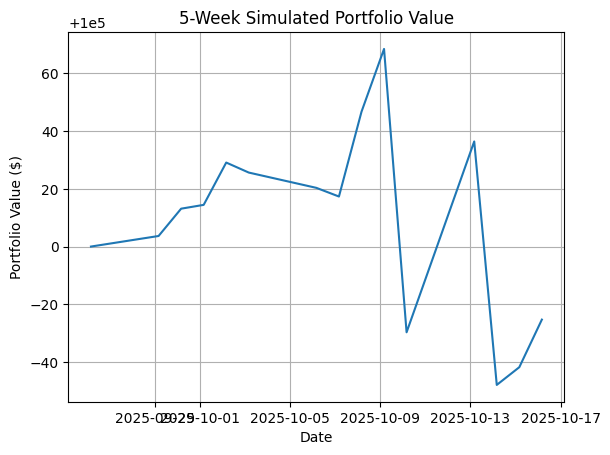

In [11]:
"""
Stock Trading Simulation Project
--------------------------------
Simulate a 5-week stock trading strategy using Polygon.io data.
Uses Logistic Regression for prediction and only trades 1 share.
Stocks: NVIDIA (NVDA), Meta (META), Microsoft (MSFT)
Model: Logistic Regression (can be replaced with RandomForest)
Starting capital: $100,000
"""

import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ==========================================================
# 1. SETUP
# ==========================================================

# Your Polygon.io API key
POLYGON_API_KEY = API_KEY  # <-- replace with your actual key

# Stocks and time window (past 5 weeks for backtesting)
tickers = ["NVDA", "META", "MSFT"]
end_date = datetime.now().date()
start_date = end_date - timedelta(weeks=5)

# ==========================================================
# 2. FETCH HISTORICAL DATA FROM POLYGON.IO
# ==========================================================

def get_polygon_data(ticker, start, end, timespan="day"):
    """
    Fetch aggregate (OHLCV) data for a stock from Polygon.io.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{timespan}/{start}/{end}"
    params = {"adjusted": "true", "sort": "asc", "limit": 50000, "apiKey": POLYGON_API_KEY}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    if "results" not in data:
        print(f"⚠️ No data for {ticker}")
        return pd.DataFrame()

    df = pd.DataFrame(data["results"])
    df["timestamp"] = pd.to_datetime(df["t"], unit="ms")
    df = df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"})
    df["Ticker"] = ticker
    return df[["timestamp", "Open", "High", "Low", "Close", "Volume", "Ticker"]]

# Pull data for all tickers
frames = []
for t in tickers:
    df = get_polygon_data(t, start_date, end_date)
    if not df.empty:
        frames.append(df)

data = pd.concat(frames).reset_index(drop=True)
print("✅ Data pulled:", data.groupby("Ticker").size())

# ==========================================================
# 3. FEATURE ENGINEERING
# ==========================================================

def add_features(df):
    """
    Add basic technical indicators for prediction.
    """
    df = df.copy()
    df["Return"] = df["Close"].pct_change()
    df["MA5"] = df["Close"].rolling(window=5).mean()
    df["MA10"] = df["Close"].rolling(window=10).mean()
    df["Volatility"] = df["Return"].rolling(window=5).std()
    df["Future_Return"] = df["Close"].shift(-1) / df["Close"] - 1
    df["Target"] = (df["Future_Return"] > 0).astype(int)  # 1 = price goes up next day
    df = df.dropna()
    return df

data = data.groupby("Ticker", group_keys=False).apply(add_features)
print("✅ Features added:", data.columns.tolist())

# ==========================================================
# 4. MODEL TRAINING
# ==========================================================

features = ["Return", "MA5", "MA10", "Volatility"]
X = data[features]
y = data["Target"]

# Train/test split (use 80% of history to train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("✅ Model trained. Accuracy:", round(accuracy_score(y_test, y_pred), 3))

# ==========================================================
# 5. SIMULATED TRADING
# ==========================================================

capital = 100_000.0
positions = {t: 0 for t in tickers}
portfolio_value = []

for date, group in data.groupby("timestamp"):
    # Predict next move for each stock
    if len(group) < len(tickers):
        continue

    X_day = group[features]
    X_day_scaled = scaler.transform(X_day)
    probs = model.predict_proba(X_day_scaled)[:, 1]  # probability of price going up
    decisions = dict(zip(group["Ticker"], probs))

    # Simple strategy: buy if p>0.55, sell if p<0.45
    for t in tickers:
        price = group[group["Ticker"] == t]["Close"].values[0]
        if decisions[t] > 0.55 and capital > price:  # buy one share
            positions[t] += 1
            capital -= price
        elif decisions[t] < 0.45 and positions[t] > 0:  # sell all
            capital += positions[t] * price
            positions[t] = 0

    # Track daily portfolio value
    total_value = capital + sum(positions[t] * group[group["Ticker"] == t]["Close"].values[0] for t in tickers)
    portfolio_value.append({"date": date, "value": total_value})

# Convert to DataFrame
portfolio_df = pd.DataFrame(portfolio_value)
print("✅ Simulation complete.")
print("Final portfolio value:", round(portfolio_df["value"].iloc[-1], 2))

# ==========================================================
# 6. PLOT RESULTS
# ==========================================================

import matplotlib.pyplot as plt

plt.plot(portfolio_df["date"], portfolio_df["value"])
plt.title("5-Week Simulated Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.show()


✅ Data pulled: Ticker
META    25
MSFT    25
NVDA    25
dtype: int64
✅ Features added: ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Return', 'MA5', 'MA10', 'Volatility', 'Future_Return', 'Target']


/tmp/ipython-input-2464722502.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("Ticker", group_keys=False).apply(add_features)


✅ Random Forest trained. Accuracy: 0.556
✅ Simulation complete.
Final portfolio value: 100145.09


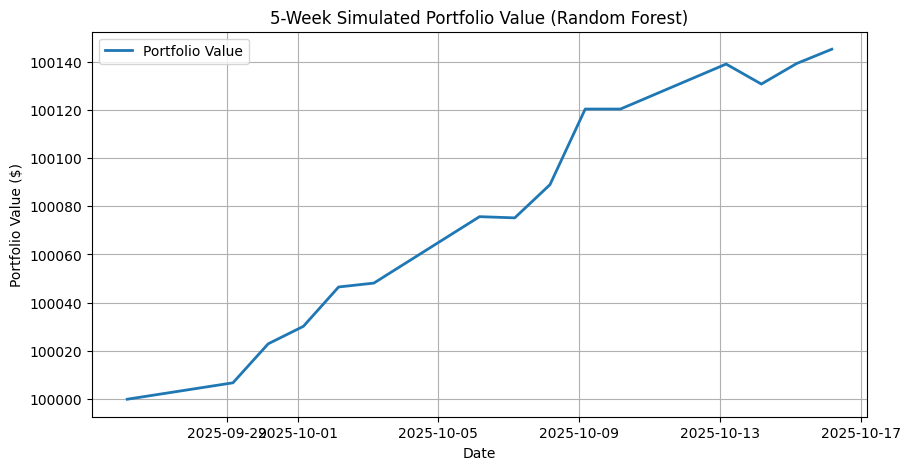

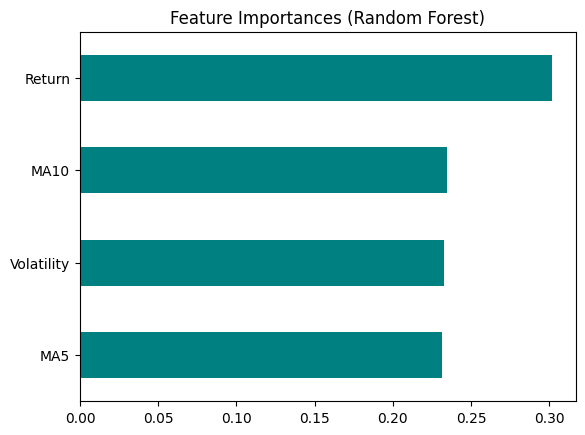

In [12]:
"""
Stock Trading Simulation Project
--------------------------------
Simulate a 5-week stock trading strategy using Polygon.io data.
Uses random forest and only trades 1 share.
Stocks: NVIDIA (NVDA), Meta (META), Microsoft (MSFT)
Model: Random Forest Classifier
Starting capital: $100,000
"""

# ==========================================================
# 1. IMPORTS & SETUP
# ==========================================================

import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Your Polygon.io API key
POLYGON_API_KEY = API_KEY  # <-- replace this with your real key

# Stocks and time window (past 5 weeks for backtesting)
tickers = ["NVDA", "META", "MSFT"]
end_date = datetime.now().date()
start_date = end_date - timedelta(weeks=5)

# ==========================================================
# 2. FETCH HISTORICAL DATA FROM POLYGON.IO
# ==========================================================

def get_polygon_data(ticker, start, end, timespan="day"):
    """
    Fetch aggregate (OHLCV) data for a stock from Polygon.io.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{timespan}/{start}/{end}"
    params = {"adjusted": "true", "sort": "asc", "limit": 50000, "apiKey": POLYGON_API_KEY}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    if "results" not in data:
        print(f"⚠️ No data for {ticker}")
        return pd.DataFrame()

    df = pd.DataFrame(data["results"])
    df["timestamp"] = pd.to_datetime(df["t"], unit="ms")
    df = df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"})
    df["Ticker"] = ticker
    return df[["timestamp", "Open", "High", "Low", "Close", "Volume", "Ticker"]]


# Pull data for all tickers
frames = []
for t in tickers:
    df = get_polygon_data(t, start_date, end_date)
    if not df.empty:
        frames.append(df)

data = pd.concat(frames).reset_index(drop=True)
print("✅ Data pulled:", data.groupby("Ticker").size())

# ==========================================================
# 3. FEATURE ENGINEERING
# ==========================================================

def add_features(df):
    """
    Add basic technical indicators for prediction.
    """
    df = df.copy()
    df["Return"] = df["Close"].pct_change()
    df["MA5"] = df["Close"].rolling(window=5).mean()
    df["MA10"] = df["Close"].rolling(window=10).mean()
    df["Volatility"] = df["Return"].rolling(window=5).std()
    df["Future_Return"] = df["Close"].shift(-1) / df["Close"] - 1
    df["Target"] = (df["Future_Return"] > 0).astype(int)  # 1 = price goes up next day
    df = df.dropna()
    return df

data = data.groupby("Ticker", group_keys=False).apply(add_features)
print("✅ Features added:", data.columns.tolist())

# ==========================================================
# 4. MODEL TRAINING (Random Forest)
# ==========================================================

features = ["Return", "MA5", "MA10", "Volatility"]
X = data[features]
y = data["Target"]

# Train/test split (80% of history to train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestClassifier(
    n_estimators=200,     # number of trees
    max_depth=5,          # control overfitting
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("✅ Random Forest trained. Accuracy:", round(accuracy_score(y_test, y_pred), 3))

# ==========================================================
# 5. SIMULATED TRADING
# ==========================================================

capital = 100_000.0
positions = {t: 0 for t in tickers}
portfolio_value = []

for date, group in data.groupby("timestamp"):
    # Predict next move for each stock
    if len(group) < len(tickers):
        continue

    X_day = group[features]
    probs = model.predict_proba(X_day)[:, 1]  # probability of price going up
    decisions = dict(zip(group["Ticker"], probs))

    # Simple strategy: buy if p>0.55, sell if p<0.45
    for t in tickers:
        price = group[group["Ticker"] == t]["Close"].values[0]
        if decisions[t] > 0.55 and capital > price:  # buy one share
            positions[t] += 1
            capital -= price
        elif decisions[t] < 0.45 and positions[t] > 0:  # sell all
            capital += positions[t] * price
            positions[t] = 0

    # Track daily portfolio value
    total_value = capital + sum(
        positions[t] * group[group["Ticker"] == t]["Close"].values[0] for t in tickers
    )
    portfolio_value.append({"date": date, "value": total_value})

# Convert to DataFrame
portfolio_df = pd.DataFrame(portfolio_value)
print("✅ Simulation complete.")
print("Final portfolio value:", round(portfolio_df["value"].iloc[-1], 2))

# ==========================================================
# 6. PLOT RESULTS
# ==========================================================

plt.figure(figsize=(10, 5))
plt.plot(portfolio_df["date"], portfolio_df["value"], label="Portfolio Value", linewidth=2)
plt.title("5-Week Simulated Portfolio Value (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 7. FEATURE IMPORTANCE (Optional)
# ==========================================================

importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", color="teal")
plt.title("Feature Importances (Random Forest)")
plt.show()


In [6]:
from sklearn.ensemble import RandomForestClassifier

# ==========================================================
# 4. MODEL TRAINING
# ==========================================================

features = ["Return", "MA5", "MA10", "Volatility"]
X = data[features]
y = data["Target"]

# Train/test split (use 80% of history to train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestClassifier(
    n_estimators=200,     # number of trees
    max_depth=5,          # limit tree depth to avoid overfitting
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("✅ Model trained. Accuracy:", round(accuracy_score(y_test, y_pred), 3))


✅ Model trained. Accuracy: 0.556


In [ ]:
# Pseudo-code: get sentiment feature via LLM
from openai import OpenAI
#client = OpenAI(api_key="YOUR_KEY")

def get_sentiment(texts):
    prompt = f"Rate the overall market sentiment of these headlines as Positive, Negative, or Neutral:\n{texts}"
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
    )
    sentiment = resp.choices[0].message.content.lower()
    if "positive" in sentiment: return 1
    if "negative" in sentiment: return -1
    return 0


In [ ]:
aggs = client.get_aggs(
    "NVDA",
    1,
    "day",
    "2025-04-04",
    "2025-04-04",
)
print(aggs)

analysis = client.list_benzinga_analyst_insights(
    "NVDA",
    "2025-04-04",
    "2025-04-04",
)

analysis_list_benzinga_ratings = client.list_benzinga_ratings(
    "NVDA",
    "2025-04-04",
    "2025-04-04",
)

print(analysis_list_benzinga_ratings)
#analysis_list = [a for a,i in zip(analysis, range(10))]
#print(analysis_list)

[Agg(open=98.91, high=100.13, low=92.11, close=94.31, volume=532273810.0, vwap=95.3341, timestamp=1743739200000, transactions=4607015, otc=None)]
<generator object BaseClient._paginate_iter at 0x7a9588353600>


In [ ]:
dir(client)

['API_KEY',
 'BASE',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_concat_headers',
 '_decode',
 '_get',
 '_get_params',
 '_paginate',
 '_paginate_iter',
 'client',
 'get_aggs',
 'get_daily_open_close_agg',
 'get_ema',
 'get_etf_global_analytics',
 'get_etf_global_constituents',
 'get_etf_global_fund_flows',
 'get_etf_global_profiles',
 'get_etf_global_taxonomies',
 'get_exchanges',
 'get_futures_contract_details',
 'get_futures_product_details',
 'get_futures_snapshot',
 'get_grouped_daily_aggs',
 'get_last_crypto_trade',
 'get_last_forex_quote',
 'get_last_quote',
 'get_last_trade',
 'get_macd',
 'get_market_holidays',
 'get_market_status',
 'get

Validation Accuracy: 0.6153846153846154


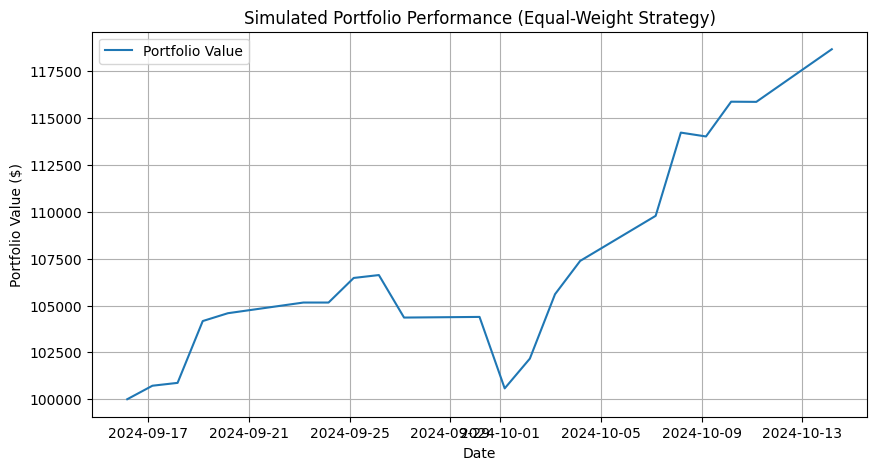

Final Portfolio Value: $118,677.04

📅 2024-09-16 Decisions:
  HOLD NVDA (0 shares, p=0.16)
  BUY 18 shares of META at $533.28 (p=0.90)
  BUY 23 shares of MSFT at $431.34 (p=0.67)
Total value: $100,000.00

📅 2024-09-17 Decisions:
  HOLD NVDA (0 shares, p=0.27)
  BUY 18 shares of META at $536.32 (p=0.83)
  SELL 23 shares of MSFT at $435.15 (p=0.08)
Total value: $100,142.26

📅 2024-09-18 Decisions:
  BUY 88 shares of NVDA at $113.37 (p=0.75)
  BUY 18 shares of META at $537.95 (p=0.89)
  BUY 23 shares of MSFT at $430.81 (p=0.82)
Total value: $100,201.12

📅 2024-09-19 Decisions:
  SELL 88 shares of NVDA at $117.87 (p=0.32)
  BUY 17 shares of META at $559.10 (p=0.83)
  SELL 23 shares of MSFT at $438.69 (p=0.20)
Total value: $101,920.46

📅 2024-09-20 Decisions:
  BUY 86 shares of NVDA at $116.00 (p=0.90)
  BUY 17 shares of META at $561.35 (p=0.74)
  HOLD MSFT (0 shares, p=0.11)
Total value: $102,080.21

📅 2024-09-23 Decisions:
  BUY 86 shares of NVDA at $116.26 (p=0.93)
  SELL 88 shares of ME

In [28]:
# ========================================
# STOCK TRADING SIMULATION (RANDOM FOREST)
# ========================================

import pandas as pd
import numpy as np
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ----------------------------------------
# 1. CONFIG
# ----------------------------------------
POLYGON_API_KEY = API_KEY
#TICKERS = ["NVDA", "META", "MSFT"]
TICKERS = ["NVDA", "META", "MSFT"]
START_DATE = "2024-09-01"
END_DATE = "2024-10-15"
INITIAL_CAPITAL = 100_000.0

# ----------------------------------------
# 2. FETCH HISTORICAL DATA
# ----------------------------------------
def get_polygon_data(ticker, start_date, end_date, api_key):
    url = (
        f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/"
        f"{start_date}/{end_date}?adjusted=true&sort=asc&limit=5000&apiKey={api_key}"
    )
    r = requests.get(url)
    data = r.json().get("results", [])
    df = pd.DataFrame(data)
    if df.empty:
        return pd.DataFrame()
    df["timestamp"] = pd.to_datetime(df["t"], unit="ms")
    df["Ticker"] = ticker
    df = df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"})
    return df[["timestamp", "Ticker", "Open", "High", "Low", "Close", "Volume"]]

# Fetch for all tickers
dfs = [get_polygon_data(t, START_DATE, END_DATE, POLYGON_API_KEY) for t in TICKERS]
data = pd.concat(dfs, ignore_index=True)

# ----------------------------------------
# 3. FEATURE ENGINEERING
# ----------------------------------------
data = data.sort_values(["Ticker", "timestamp"])

data["Return"] = data.groupby("Ticker")["Close"].pct_change()
data["MA5"] = data.groupby("Ticker")["Close"].transform(lambda x: x.rolling(5).mean())
data["MA10"] = data.groupby("Ticker")["Close"].transform(lambda x: x.rolling(10).mean())
data["Volatility"] = data.groupby("Ticker")["Return"].transform(lambda x: x.rolling(5).std())
data["Future_Return"] = data.groupby("Ticker")["Close"].shift(-1) / data["Close"] - 1
data["Target"] = (data["Future_Return"] > 0).astype(int)

data = data.dropna()

features = ["Return", "MA5", "MA10", "Volatility"]
target = "Target"

# ----------------------------------------
# 4. TRAIN RANDOM FOREST
# ----------------------------------------
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
print("Validation Accuracy:", accuracy_score(y_test, model.predict(X_test)))



# ----------------------------------------
# 5. SIMULATION LOOP (Equal-weight investing)
# ----------------------------------------
capital = INITIAL_CAPITAL
positions = {t: 0 for t in TICKERS}
portfolio_values = []

for date, group in data.groupby("timestamp"):
    X_day = group[features]
    probs = model.predict_proba(X_day)[:, 1]
    decisions = dict(zip(group["Ticker"], probs))

    # Value of current holdings
    equity_value = sum(
        positions[t] * group[group["Ticker"] == t]["Close"].values[0] for t in TICKERS
    )
    total_value = capital + equity_value

    # Determine bullish tickers
    bullish = [t for t in TICKERS if decisions[t] > 0.55]

    if bullish:
        invest_per_stock = total_value / len(bullish)

        for t in TICKERS:
            price = group[group["Ticker"] == t]["Close"].values[0]

            # If bullish, hold or buy up to target value
            if t in bullish:
                target_value = invest_per_stock
                current_value = positions[t] * price
                if current_value < target_value:
                    shares_to_buy = int((target_value - current_value) / price)
                    cost = shares_to_buy * price
                    if cost <= capital:
                        positions[t] += shares_to_buy
                        capital -= cost
            # If bearish, sell any existing shares
            else:
                if positions[t] > 0:
                    capital += positions[t] * price
                    positions[t] = 0

    portfolio_values.append({"Date": date, "TotalValue": total_value, "Cash": capital})

portfolio_df = pd.DataFrame(portfolio_values)
# ----------------------------------------
# 6. PLOT RESULTS
# ----------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df["Date"], portfolio_df["TotalValue"], label="Portfolio Value")
plt.title("Simulated Portfolio Performance (Equal-Weight Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Final summary
print(f"Final Portfolio Value: ${portfolio_df['TotalValue'].iloc[-1]:,.2f}")


# ==========================================================
# SIMULATED TRADING WITH SHARE COUNTS
# ==========================================================
capital = 100_000.0
positions = {t: 0 for t in TICKERS}
portfolio_value = []
allocation_per_trade = 10_000  # dollars to invest per stock when BUY

for date, group in data.groupby("timestamp"):
    if len(group) < len(TICKERS):
        continue

    X_day = group[features]
    X_day_scaled = scaler.transform(X_day)
    probs = rf.predict_proba(X_day_scaled)[:, 1]
    decisions = dict(zip(group["Ticker"], probs))

    print(f"\n📅 {date.date()} Decisions:")

    for t in TICKERS:
        price = group[group["Ticker"] == t]["Close"].values[0]
        prob = decisions[t]

        if prob > 0.55 and capital > price:
            # Buy shares worth $10,000 (or as much as possible)
            num_shares = int(allocation_per_trade // price)
            cost = num_shares * price
            if num_shares > 0 and capital >= cost:
                positions[t] += num_shares
                capital -= cost
                print(f"  BUY {num_shares} shares of {t} at ${price:.2f} (p={prob:.2f})")

        elif prob < 0.45 and positions[t] > 0:
            # Sell all held shares
            proceeds = positions[t] * price
            capital += proceeds
            print(f"  SELL {positions[t]} shares of {t} at ${price:.2f} (p={prob:.2f})")
            positions[t] = 0

        else:
            print(f"  HOLD {t} ({positions[t]} shares, p={prob:.2f})")

    # Track daily total value
    total_value = capital + sum(
        positions[t] * group[group["Ticker"] == t]["Close"].values[0] for t in TICKERS
    )
    portfolio_value.append({"date": date, "value": total_value})
    print(f"Total value: ${total_value:,.2f}")
portfolio_df = pd.DataFrame(portfolio_value)
print("\n✅ Simulation complete. Final value:", round(portfolio_df['value'].iloc[-1], 2))


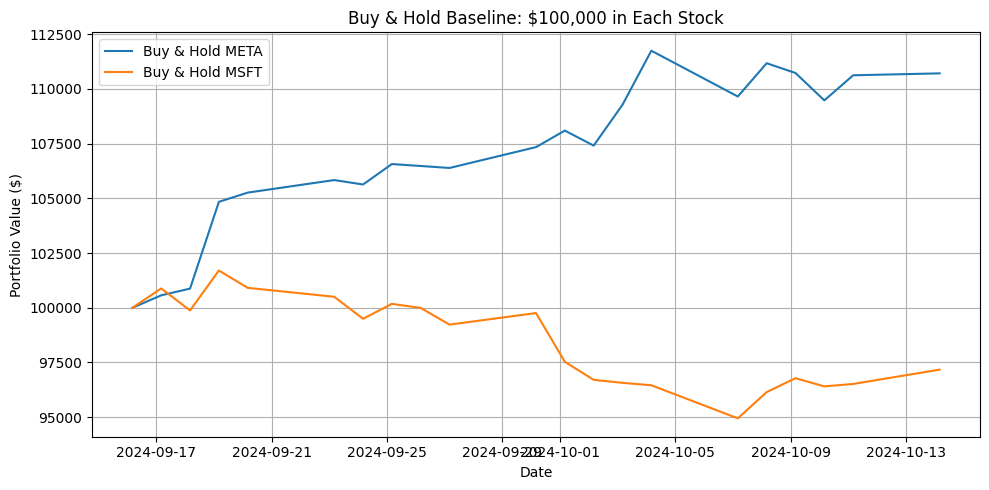

📈 Final Portfolio Values:
META: $110,714.82  (10.71%)
MSFT: $97,171.60  (-2.83%)


In [14]:
# ==========================================================
# BASELINE COMPARISON: Buy & Hold Each Stock
# ==========================================================

import matplotlib.pyplot as plt

initial_capital = INITIAL_CAPITAL
baseline_values = {}

plt.figure(figsize=(10, 5))

for ticker in TICKERS:
    df_t = data[data["Ticker"] == ticker].copy().sort_values("timestamp")
    if df_t.empty:
        print(f"⚠️ No data for {ticker}, skipping.")
        continue

    initial_price = df_t["Close"].iloc[0]
    shares = initial_capital / initial_price
    df_t["Portfolio_Value"] = shares * df_t["Close"]
    baseline_values[ticker] = df_t

    plt.plot(df_t["timestamp"], df_t["Portfolio_Value"], label=f"Buy & Hold {ticker}")

# Plot styling
plt.title("Buy & Hold Baseline: $100,000 in Each Stock")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary
print("📈 Final Portfolio Values:")
for ticker, df_t in baseline_values.items():
    start_val = df_t["Portfolio_Value"].iloc[0]
    end_val = df_t["Portfolio_Value"].iloc[-1]
    pct_return = (end_val - start_val) / start_val * 100
    print(f"{ticker}: ${end_val:,.2f}  ({pct_return:.2f}%)")


✅ Data fetched: Ticker
META    49
MSFT    49
NVDA    49
dtype: int64
✅ Features added: ['timestamp', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA5', 'MA10', 'Volatility', 'Future_Return', 'Target']


/tmp/ipython-input-69466258.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("Ticker", group_keys=False).apply(add_features)


✅ Random Forest accuracy: 0.417


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyobp8tgd/as0auxk2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyobp8tgd/eo6mzvmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66010', 'data', 'file=/tmp/tmpyobp8tgd/as0auxk2.json', 'init=/tmp/tmpyobp8tgd/eo6mzvmh.json', 'output', 'file=/tmp/tmpyobp8tgd/prophet_modelwnqabl22/prophet_model-20251019165542.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:55:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Simulation complete. Final value: 100415.47


16:55:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyobp8tgd/9nj48w8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyobp8tgd/a7kiktwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92059', 'data', 'file=/tmp/tmpyobp8tgd/9nj48w8r.json', 'init=/tmp/tmpyobp8tgd/a7kiktwf.json', 'output', 'file=/tmp/tmpyobp8tgd/prophet_modelb6s21kob/prophet_model-20251019165542.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:55:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:55:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality.

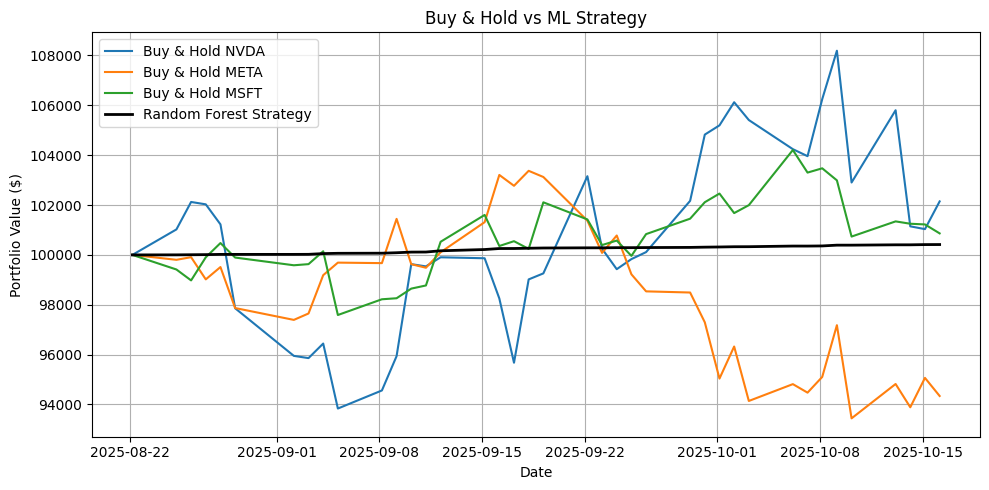


📈 Final Portfolio Values:
NVDA: $102,146.19 (2.15%)
META: $94,340.15 (-5.66%)
MSFT: $100,863.51 (0.86%)
Model strategy final value: $100,415.47


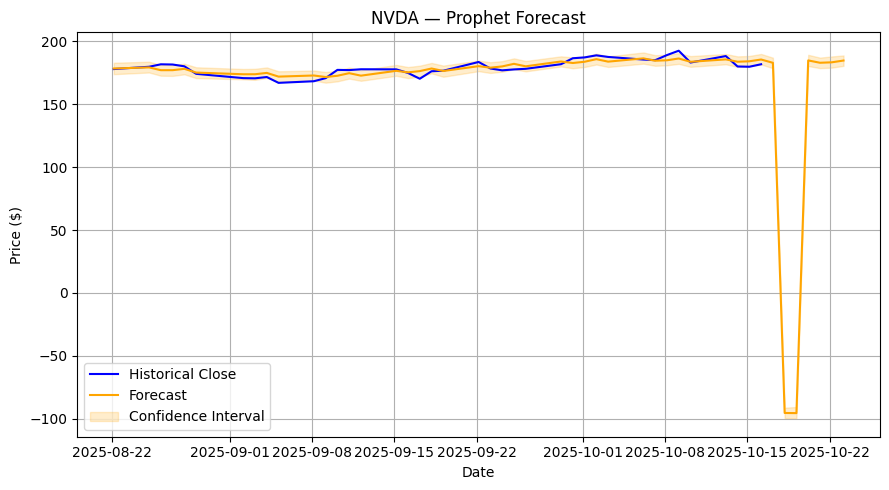

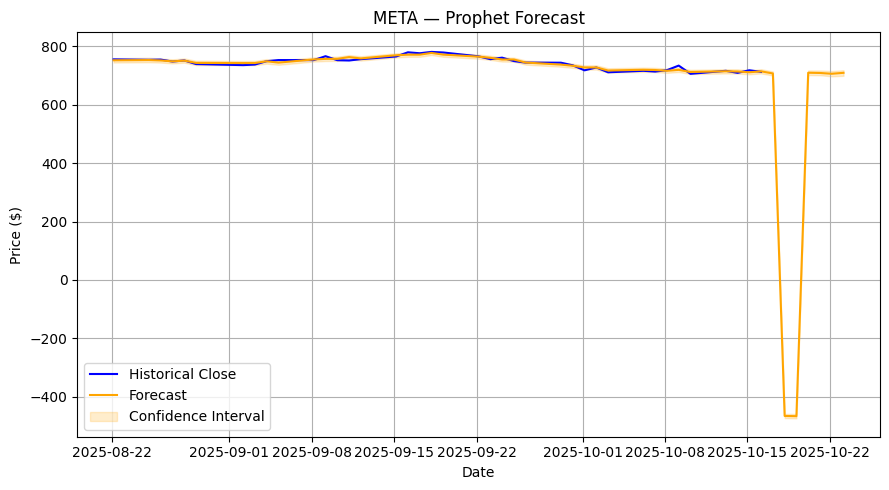

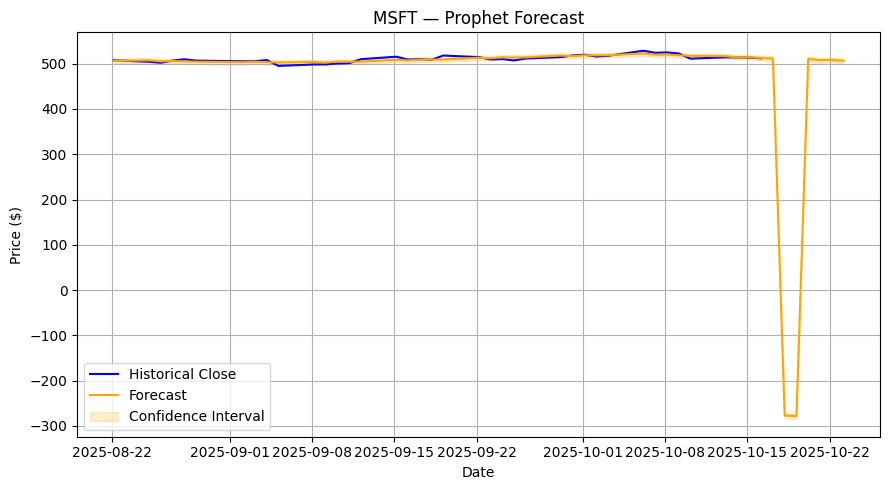

In [10]:
"""
Stock Market Decision Model (Polygon.io + ML + Prophet)
-------------------------------------------------------
Stocks: NVIDIA (NVDA), Meta (META), Microsoft (MSFT)
Start capital: $100,000
Models: Random Forest Classifier + Prophet Forecast
Period: Past 10 weeks (simulate 5-week trading window)
"""

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Optional: Prophet for time series forecasting
from prophet import Prophet

# ==========================================================
# 1. SETUP
# ==========================================================
POLYGON_API_KEY = API_KEY  # <-- replace with your own
TICKERS = ["NVDA", "META", "MSFT"]
END_DATE = datetime.now().date()
START_DATE = END_DATE - timedelta(weeks=10)
INITIAL_CAPITAL = 100_000.0

# ==========================================================
# 2. FETCH HISTORICAL DATA FROM POLYGON.IO
# ==========================================================
def get_polygon_data(ticker, start_date, end_date, api_key):
    url = (
        f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/"
        f"{start_date}/{end_date}?adjusted=true&sort=asc&limit=5000&apiKey={api_key}"
    )
    r = requests.get(url)
    data = r.json().get("results", [])
    df = pd.DataFrame(data)
    if df.empty:
        print(f"⚠️ No data found for {ticker}")
        return pd.DataFrame()
    df["timestamp"] = pd.to_datetime(df["t"], unit="ms")
    df["Ticker"] = ticker
    df = df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"})
    return df[["timestamp", "Ticker", "Open", "High", "Low", "Close", "Volume"]]

dfs = [get_polygon_data(t, START_DATE, END_DATE, POLYGON_API_KEY) for t in TICKERS]
data = pd.concat(dfs, ignore_index=True)
print("✅ Data fetched:", data.groupby("Ticker").size())

# ==========================================================
# 3. FEATURE ENGINEERING
# ==========================================================
def add_features(df):
    df = df.copy()
    df["Return"] = df["Close"].pct_change()
    df["MA5"] = df["Close"].rolling(5).mean()
    df["MA10"] = df["Close"].rolling(10).mean()
    df["Volatility"] = df["Return"].rolling(5).std()
    df["Future_Return"] = df["Close"].shift(-1) / df["Close"] - 1
    df["Target"] = (df["Future_Return"] > 0).astype(int)
    return df.dropna()

data = data.groupby("Ticker", group_keys=False).apply(add_features)
print("✅ Features added:", data.columns.tolist())

# ==========================================================
# 4. RANDOM FOREST MODEL
# ==========================================================
features = ["Return", "MA5", "MA10", "Volatility"]
X = data[features]
y = data["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print("✅ Random Forest accuracy:", round(accuracy_score(y_test, y_pred), 3))

# ==========================================================
# 5. TRADING SIMULATION
# ==========================================================
capital = INITIAL_CAPITAL
positions = {t: 0 for t in TICKERS}
portfolio_value = []

for date, group in data.groupby("timestamp"):
    if len(group) < len(TICKERS):
        continue
    X_day = group[features]
    X_day_scaled = scaler.transform(X_day)
    probs = rf.predict_proba(X_day_scaled)[:, 1]  # prob that price goes up
    decisions = dict(zip(group["Ticker"], probs))

    for t in TICKERS:
        price = group[group["Ticker"] == t]["Close"].values[0]
        if decisions[t] > 0.55 and capital > price:
            positions[t] += 1
            capital -= price
        elif decisions[t] < 0.45 and positions[t] > 0:
            capital += positions[t] * price
            positions[t] = 0

    total_value = capital + sum(
        positions[t] * group[group["Ticker"] == t]["Close"].values[0] for t in TICKERS
    )
    portfolio_value.append({"date": date, "value": total_value})

portfolio_df = pd.DataFrame(portfolio_value)
print("✅ Simulation complete. Final value:", round(portfolio_df['value'].iloc[-1], 2))

# ==========================================================
# 6. PROPHET FORECAST (OPTIONAL)
# ==========================================================
prophet_forecasts = {}
for ticker in TICKERS:
    df_t = data[data["Ticker"] == ticker][["timestamp", "Close"]].rename(
        columns={"timestamp": "ds", "Close": "y"}
    )
    m = Prophet(daily_seasonality=False, weekly_seasonality=True)
    m.fit(df_t)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    prophet_forecasts[ticker] = forecast

# ==========================================================
# 7. BUY & HOLD BASELINES
# ==========================================================
baseline_values = {}
plt.figure(figsize=(10, 5))
for ticker in TICKERS:
    df_t = data[data["Ticker"] == ticker].sort_values("timestamp")
    initial_price = df_t["Close"].iloc[0]
    shares = INITIAL_CAPITAL / initial_price
    df_t["Portfolio_Value"] = shares * df_t["Close"]
    baseline_values[ticker] = df_t
    plt.plot(df_t["timestamp"], df_t["Portfolio_Value"], label=f"Buy & Hold {ticker}")

plt.plot(portfolio_df["date"], portfolio_df["value"], color="black", linewidth=2, label="Random Forest Strategy")
plt.title("Buy & Hold vs ML Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print("\n📈 Final Portfolio Values:")
for ticker, df_t in baseline_values.items():
    start_val = df_t["Portfolio_Value"].iloc[0]
    end_val = df_t["Portfolio_Value"].iloc[-1]
    pct = (end_val - start_val) / start_val * 100
    print(f"{ticker}: ${end_val:,.2f} ({pct:.2f}%)")
print(f"Model strategy final value: ${portfolio_df['value'].iloc[-1]:,.2f}")
# ==========================================================
# 6B. PROPHET FORECAST VISUALIZATION
# ==========================================================

for ticker, forecast in prophet_forecasts.items():
    df_t = data[data["Ticker"] == ticker][["timestamp", "Close"]].rename(
        columns={"timestamp": "ds", "Close": "y"}
    )

    plt.figure(figsize=(9, 5))
    plt.plot(df_t["ds"], df_t["y"], label="Historical Close", color="blue")
    plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="orange")
    plt.fill_between(
        forecast["ds"],
        forecast["yhat_lower"],
        forecast["yhat_upper"],
        color="orange",
        alpha=0.2,
        label="Confidence Interval"
    )

    plt.title(f"{ticker} — Prophet Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
